### 01 — Exploratory Data Analysis (MovieLens 100K)

Goals:
- Inspect raw files (`ratings.csv`, `movies.csv`, `tags.csv`).
- Verify schema, types, missing values.
- Understand user/item counts, rating distribution, sparsity.
- Explore genres, top movies, most active users, and time trends.
- Save summary tables and figures into `reports/figures/`.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))
from data_loader import (
    load_ratings, load_movies, load_tags
)

# Define paths
RAW  = BASE / 'data' / 'raw'
FIGS = BASE / 'reports' / 'figures'
FIGS.mkdir(parents=True, exist_ok=True)

# Define data file paths
ratings_path = RAW / 'ratings.csv'
movies_path  = RAW / 'movies.csv'
tags_path    = RAW / 'tags.csv'

# Check existence of data files
print('RAW exists:', RAW.exists())
print('ratings.csv:', ratings_path.exists(), 'movies.csv:', movies_path.exists(), 'tags.csv:', tags_path.exists())
assert ratings_path.exists() and movies_path.exists(), "Please copy ratings.csv and movies.csv into data/raw/"


RAW exists: True
ratings.csv: True movies.csv: True tags.csv: True


In [2]:
# Read CSVs with appropriate dtypes
ratings = load_ratings(str(ratings_path))
movies = load_movies(str(movies_path))
tags = load_tags(str(tags_path))

print(ratings.shape, movies.shape, tags.shape)
ratings.head()


2025-12-06 13:05:47,722 | INFO | data_loader | Loading ratings from /Users/alanyu/Documents/IIT/ITM/ITMD-524-Applied_AI_and_Deep_Learning/finalproject/MovieLens-MCRS/data/raw/ratings.csv
2025-12-06 13:05:47,760 | INFO | data_loader | Loading movies from /Users/alanyu/Documents/IIT/ITM/ITMD-524-Applied_AI_and_Deep_Learning/finalproject/MovieLens-MCRS/data/raw/movies.csv
2025-12-06 13:05:47,766 | INFO | data_loader | Loading tags from /Users/alanyu/Documents/IIT/ITM/ITMD-524-Applied_AI_and_Deep_Learning/finalproject/MovieLens-MCRS/data/raw/tags.csv


(100836, 5) (9742, 3) (3683, 5)


,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


### Basic Info & Missing Values

In [3]:
# Basic Info & Missing Values
display(ratings.info())
display(movies.info())
display(tags.info())

# Missing value proportions
ratings_na = ratings.isna().mean().sort_values(ascending=False)
movies_na = movies.isna().mean().sort_values(ascending=False)
tags_na = tags.isna().mean().sort_values(ascending=False)

# Display missing value proportions
display(ratings_na.head(10), movies_na.head(10), tags_na.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int32         
 1   movieId    100836 non-null  int32         
 2   rating     100836 non-null  float32       
 3   timestamp  100836 non-null  int64         
 4   datetime   100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2), int64(1)
memory usage: 2.7 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   string
 2   genres   9742 non-null   string
dtypes: int32(1), string(2)
memory usage: 190.4 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     3683 non-null   int32         
 1   movieId    3683 non-null   int32         
 2   tag        3683 non-null   string        
 3   timestamp  3683 non-null   int64         
 4   datetime   3683 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1), string(1)
memory usage: 115.2 KB


None

userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
datetime     0.0
dtype: float64

movieId    0.0
title      0.0
genres     0.0
dtype: float64

userId       0.0
movieId      0.0
tag          0.0
timestamp    0.0
datetime     0.0
dtype: float64

### Users, Movies, Interactions, Sparsity

In [ ]:
# Calculate sparsity
# Sparsity refers to how many missing values exist in the user–movie rating matrix.
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()
n_inter = len(ratings)
sparsity = 1 - (n_inter / (n_users * n_items))
summary = pd.DataFrame({
    'n_users':[n_users], 'n_movies':[n_items], 'n_ratings':[n_inter], 'sparsity':[sparsity]
})
summary


,n_users,n_movies,n_ratings,sparsity
0,610,9724,100836,0.983


### Rating Distribution

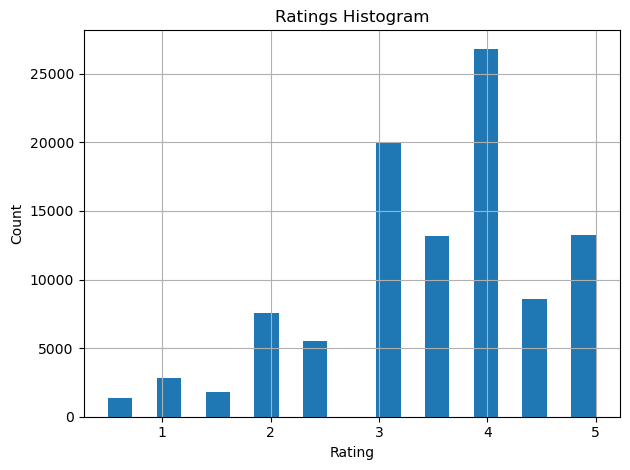

In [ ]:
# Ratings Histogram
plt.figure()
ratings['rating'].hist(bins=20)
plt.title('Ratings Histogram')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(FIGS / 'ratings_histogram.png')
plt.show()


In [14]:
rating_counts = ratings['rating'].value_counts().sort_index()

rating_table = rating_counts.reset_index()
rating_table.columns = ['rating', 'count']

rating_table

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


### Top Movies by Number of Ratings

In [13]:
# Top 10 Most Rated Movies
movie_counts = ratings.groupby('movieId')['userId'].count().sort_values(ascending=False).head(10)
top_movies = movies.set_index('movieId').loc[movie_counts.index][['title']].copy()
top_movies['n_ratings'] = movie_counts.values
top_movies.reset_index(inplace=True)
top_movies


,movieId,title,n_ratings
0,356,Forrest Gump (1994),329
1,318,"Shawshank Redemption, The (1994)",317
2,296,Pulp Fiction (1994),307
3,593,"Silence of the Lambs, The (1991)",279
4,2571,"Matrix, The (1999)",278
5,260,Star Wars: Episode IV - A New Hope (1977),251
6,480,Jurassic Park (1993),238
7,110,Braveheart (1995),237
8,589,Terminator 2: Judgment Day (1991),224
9,527,Schindler's List (1993),220


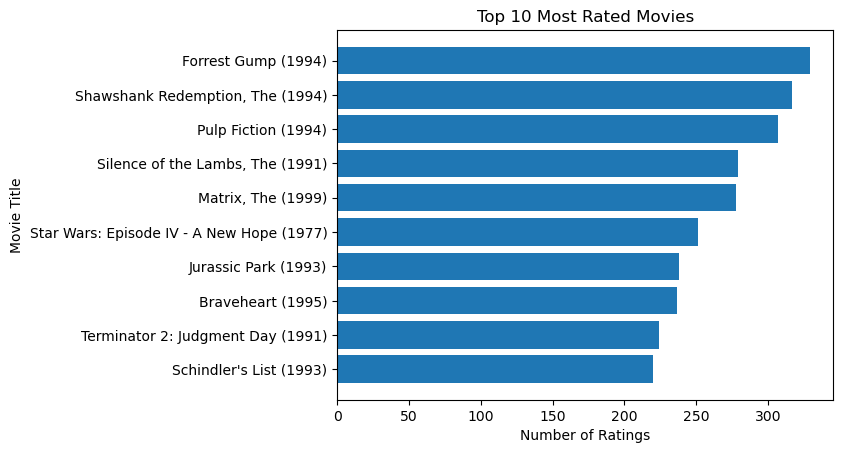

In [18]:
plt.barh(top_movies['title'], top_movies['n_ratings'])
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Rated Movies")

# Reverse order so the highest is on top
plt.gca().invert_yaxis()

plt.show()

### Most Active Users

In [20]:
active_users = ratings['userId'].value_counts().reset_index(name='n_ratings').head(10)
active_users


,userId,n_ratings
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
5,610,1302
6,68,1260
7,380,1218
8,606,1115
9,288,1055


### Temporal Trends (Monthly Ratings Count)

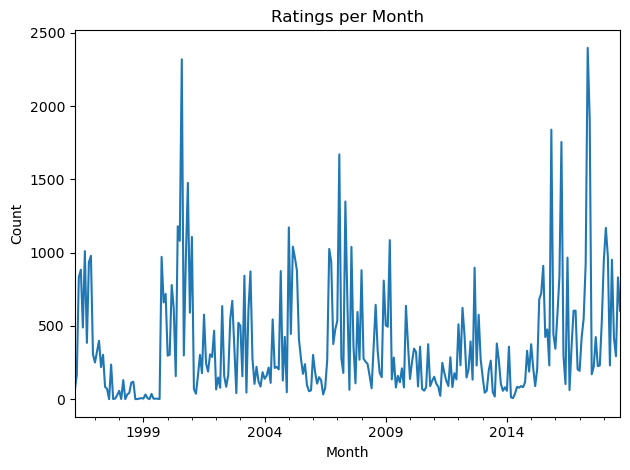

In [24]:
if 'datetime' in ratings.columns:
    # Monthly Ratings Count(Month Start)
    monthly = ratings.set_index('datetime').resample('MS')['rating'].count()
    plt.figure()
    monthly.plot()
    plt.title('Ratings per Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(FIGS / 'ratings_per_month.png')
    plt.show()
else:
    print("No datetime column parsed; skip temporal plot.")


### Genres: frequency and average ratings

In [27]:
# Explode pipe-separated genres
g = movies[['movieId','genres']].copy()
g['genres'] = g['genres'].fillna('')
g = g.assign(genre=g['genres'].str.split('|')).explode('genre')
g = g[g['genre'].notna() & (g['genre']!='(no genres listed)') & (g['genre']!='')]

# join with ratings to compute counts and mean rating per genre
gr = ratings.merge(g[['movieId','genre']], on='movieId', how='left')
genre_stats = gr.groupby('genre')['rating'].agg(['count','mean']).sort_values('count', ascending=False)
genre_stats.head(10)

,count,mean
genre,,
Drama,41928,3.656184
Comedy,39053,3.384721
Action,30635,3.447984
Thriller,26452,3.493706
Adventure,24161,3.508609
Romance,18124,3.506511
Sci-Fi,17243,3.455721
Crime,16681,3.658294
Fantasy,11834,3.491000


### Save key tables

In [26]:
# Save key tables
summary.to_csv(BASE / 'reports' / 'eda_summary.csv', index=False)
top_movies.to_csv(BASE / 'reports' / 'top_movies.csv', index=False)
active_users.to_csv(BASE / 'reports' / 'active_users.csv', index=False)
genre_stats.to_csv(BASE / 'reports' / 'genre_stats.csv')
print('Saved tables to', BASE / 'reports')


Saved tables to /Users/alanyu/Documents/IIT/ITM/ITMD-524-Applied_AI_and_Deep_Learning/finalproject/MovieLens-MCRS/reports
